In [1]:
import numpy as np
import pandas as pd
import datetime
import gc

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
np.random.seed(4590)

/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/naoki/.pyenv/versions/3.6.6/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew in

In [2]:
df_train = pd.read_csv('../input/train.csv')
df_test = pd.read_csv('../input/test.csv')
df_hist_trans = pd.read_csv('../input/historical_transactions.csv')
df_new_merchant_trans = pd.read_csv('../input/new_merchant_transactions.csv')

In [3]:
df_train["target_sign"] = df_train.target.apply(lambda x:0 if x<0 else 1)

In [4]:
df_hist_trans['purchase_amount'] = np.exp(df_hist_trans['purchase_amount'])
df_new_merchant_trans['purchase_amount'] = np.exp(df_new_merchant_trans['purchase_amount'])

In [5]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['category_2'].fillna(1.0,inplace=True)
    df['category_3'].fillna('A',inplace=True)
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)

In [6]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [7]:
for df in [df_hist_trans,df_new_merchant_trans]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['weekofyear'] = df['purchase_date'].dt.weekofyear
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['authorized_flag'] = df['authorized_flag'].map({'Y':1, 'N':0})
    df['category_1'] = df['category_1'].map({'Y':1, 'N':0}) 
    #https://www.kaggle.com/c/elo-merchant-category-recommendation/discussion/73244
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']

In [8]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_hist_trans[col+'_mean'] = df_hist_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    

new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = df_hist_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['hist_purchase_date_diff'] = (df_hist_trans_group['hist_purchase_date_max'] - df_hist_trans_group['hist_purchase_date_min']).dt.days
df_hist_trans_group['hist_purchase_date_average'] = df_hist_trans_group['hist_purchase_date_diff']/df_hist_trans_group['hist_card_id_size']
df_hist_trans_group['hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

42

In [9]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']
aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean']
aggs['weekend'] = ['sum', 'mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']

for col in ['category_2','category_3']:
    df_new_merchant_trans[col+'_mean'] = df_new_merchant_trans.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']
    
new_columns = get_new_columns('new_hist',aggs)
df_hist_trans_group = df_new_merchant_trans.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
df_hist_trans_group['new_hist_purchase_date_diff'] = (df_hist_trans_group['new_hist_purchase_date_max'] - df_hist_trans_group['new_hist_purchase_date_min']).dt.days
df_hist_trans_group['new_hist_purchase_date_average'] = df_hist_trans_group['new_hist_purchase_date_diff']/df_hist_trans_group['new_hist_card_id_size']
df_hist_trans_group['new_hist_purchase_date_uptonow'] = (datetime.datetime.today() - df_hist_trans_group['new_hist_purchase_date_max']).dt.days
df_train = df_train.merge(df_hist_trans_group,on='card_id',how='left')
df_test = df_test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;gc.collect()

28

In [10]:
del df_hist_trans;gc.collect()
del df_new_merchant_trans;gc.collect()
df_train.head(5)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,target_sign,hist_month_nunique,hist_hour_nunique,hist_weekofyear_nunique,...,new_hist_weekend_sum,new_hist_weekend_mean,new_hist_category_1_sum,new_hist_category_1_mean,new_hist_card_id_size,new_hist_category_2_mean_mean,new_hist_category_3_mean_mean,new_hist_purchase_date_diff,new_hist_purchase_date_average,new_hist_purchase_date_uptonow
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,0,9,23,35,...,6.0,0.260870,0.0,0.000000,23.0,1.658319e+108,1.381361e+36,54.0,2.347826,238.0
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,1,12,24,50,...,0.0,0.000000,0.0,0.000000,6.0,1.658319e+108,3.557623e+25,56.0,9.333333,268.0
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,1,10,14,22,...,1.0,1.000000,0.0,0.000000,1.0,7.789907e+26,1.381361e+36,0.0,0.000000,238.0
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,1,6,16,20,...,3.0,0.428571,1.0,0.142857,7.0,2.369028e+107,1.973373e+35,41.0,5.857143,249.0
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,0,4,22,17,...,12.0,0.333333,2.0,0.055556,36.0,1.842577e+107,3.624714e+107,57.0,1.583333,238.0


In [11]:
df_train['outliers'] = 0
df_train.loc[df_train['target'] < -30, 'outliers'] = 1
df_train['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [12]:
list_outlier_idx = df_train[df_train.outliers == 1].index.tolist()

In [13]:
for df in [df_train,df_test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days
    for f in ['hist_purchase_date_max','hist_purchase_date_min','new_hist_purchase_date_max',\
                     'new_hist_purchase_date_min']:
        df[f] = df[f].astype(np.int64) * 1e-9
    df['card_id_total'] = df['new_hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['new_hist_purchase_amount_sum']+df['hist_purchase_amount_sum']

for f in ['feature_1','feature_2','feature_3']:
    order_label = df_train.groupby([f])['outliers'].mean()
    df_train[f] = df_train[f].map(order_label)
    df_test[f] = df_test[f].map(order_label)

In [14]:
high_importance_features = [
    "hist_month_diff_mean", 
    "hist_authorized_flag_mean", 
    "hist_category_1_sum", 
    "hist_month_lag_mean", 
    "new_hist_purchase_amount_sum", 
    "new_hist_purchase_date_uptonow"
]

#smoothing
for col in high_importance_features:
    df_train[col] = np.where(df_train[col].values==0, 0.001, df_train[col].values)
    df_test[col] = np.where(df_test[col].values==0, 0.001, df_test[col].values)


for i in range(len(high_importance_features)):
    for j in range(len((high_importance_features)))[i+1:]:
        col1 = high_importance_features[i]
        col2 = high_importance_features[j]
        new_col_name = "{c1}__div__{c2}".format(c1=col1, c2=col2)
        
        df_train[new_col_name] = df_train[col1] / df_train[col2]
        df_test[new_col_name] = df_test[col1] / df_test[col2]

In [15]:
def merge_new_feature(path):
    df_new_feature = pd.read_csv(path)
    
    df_tr = pd.merge(df_train, df_new_feature, on="card_id", how="left")
    df_te = pd.merge(df_test, df_new_feature, on="card_id", how="left")
    
    return df_tr, df_te

In [16]:
df_train, df_test = merge_new_feature("../input/merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/new_merchants_nmf.csv")
df_train, df_test = merge_new_feature("../input/prosperity_merchants_latest.csv")
df_train, df_test = merge_new_feature("../input/merchants_numerical_features.csv")
df_train, df_test = merge_new_feature("../input/merchants_item_scale_feature.csv")
df_train, df_test = merge_new_feature("../input/purchase_pattern.csv")
df_train, df_test = merge_new_feature("../input/purchase_pettern_nmf.csv")
df_train, df_test = merge_new_feature("../input/purchase_amount_pettern_nmf.csv")
df_train, df_test = merge_new_feature("../input/trs_category_summary.csv")

In [17]:
df_train["Null_count"] = df_train.isnull().sum(axis=1)
df_test["Null_count"] = df_test.isnull().sum(axis=1)

In [18]:
drop_col = ['card_id', 'first_active_month','second_active_date','diff_first_and_second','target','outliers', 'target_sign']
df_train_columns = [c for c in df_train.columns if c not in drop_col]


df_train_null = df_train.isnull().sum().reset_index()
df_train_null.columns = ["col_name", "null_count"]
for i,r in df_train_null.iterrows():
    if r[1] > 0:
        drop_col.append(r[0])
        
target = df_train['target']
target_outliers = df_train["outliers"]

In [19]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.7384	valid_1's rmse: 3.77474
[200]	training's rmse: 3.66917	valid_1's rmse: 3.73415
[300]	training's rmse: 3.62056	valid_1's rmse: 3.71107
[400]	training's rmse: 3.5832	valid_1's rmse: 3.69743
[500]	training's rmse: 3.55355	valid_1's rmse: 3.68688
[600]	training's rmse: 3.52899	valid_1's rmse: 3.67968
[700]	training's rmse: 3.50823	valid_1's rmse: 3.67461
[800]	training's rmse: 3.48993	valid_1's rmse: 3.67053
[900]	training's rmse: 3.47308	valid_1's rmse: 3.66687
[1000]	training's rmse: 3.45751	valid_1's rmse: 3.66405
[1100]	training's rmse: 3.44318	valid_1's rmse: 3.66147
[1200]	training's rmse: 3.4299	valid_1's rmse: 3.6592
[1300]	training's rmse: 3.41701	valid_1's rmse: 3.65736
[1400]	training's rmse: 3.40527	valid_1's rmse: 3.65584
[1500]	training's rmse: 3.39334	valid_1's rmse: 3.6542
[1600]	training's rmse: 3.38186	valid_1's rmse: 3.65298
[1700]	training's rmse: 3.3712	valid_1's rmse: 3

[1600]	training's rmse: 3.37192	valid_1's rmse: 3.66903
[1700]	training's rmse: 3.36098	valid_1's rmse: 3.66859
[1800]	training's rmse: 3.35016	valid_1's rmse: 3.6682
[1900]	training's rmse: 3.33989	valid_1's rmse: 3.66796
[2000]	training's rmse: 3.3298	valid_1's rmse: 3.66761
[2100]	training's rmse: 3.31998	valid_1's rmse: 3.66728
[2200]	training's rmse: 3.31066	valid_1's rmse: 3.66708
[2300]	training's rmse: 3.30155	valid_1's rmse: 3.66684
[2400]	training's rmse: 3.2925	valid_1's rmse: 3.66668
[2500]	training's rmse: 3.28409	valid_1's rmse: 3.66664
[2600]	training's rmse: 3.27532	valid_1's rmse: 3.6667
[2700]	training's rmse: 3.26744	valid_1's rmse: 3.66663
[2800]	training's rmse: 3.25911	valid_1's rmse: 3.66661
Early stopping, best iteration is:
[2472]	training's rmse: 3.28643	valid_1's rmse: 3.66652
fold 4
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.73821	valid_1's rmse: 3.77816
[200]	training's rmse: 3.66802	valid_1's rmse: 3.73629
[300]

3.645372957557951

In [20]:
# score:  3.6467757129353053

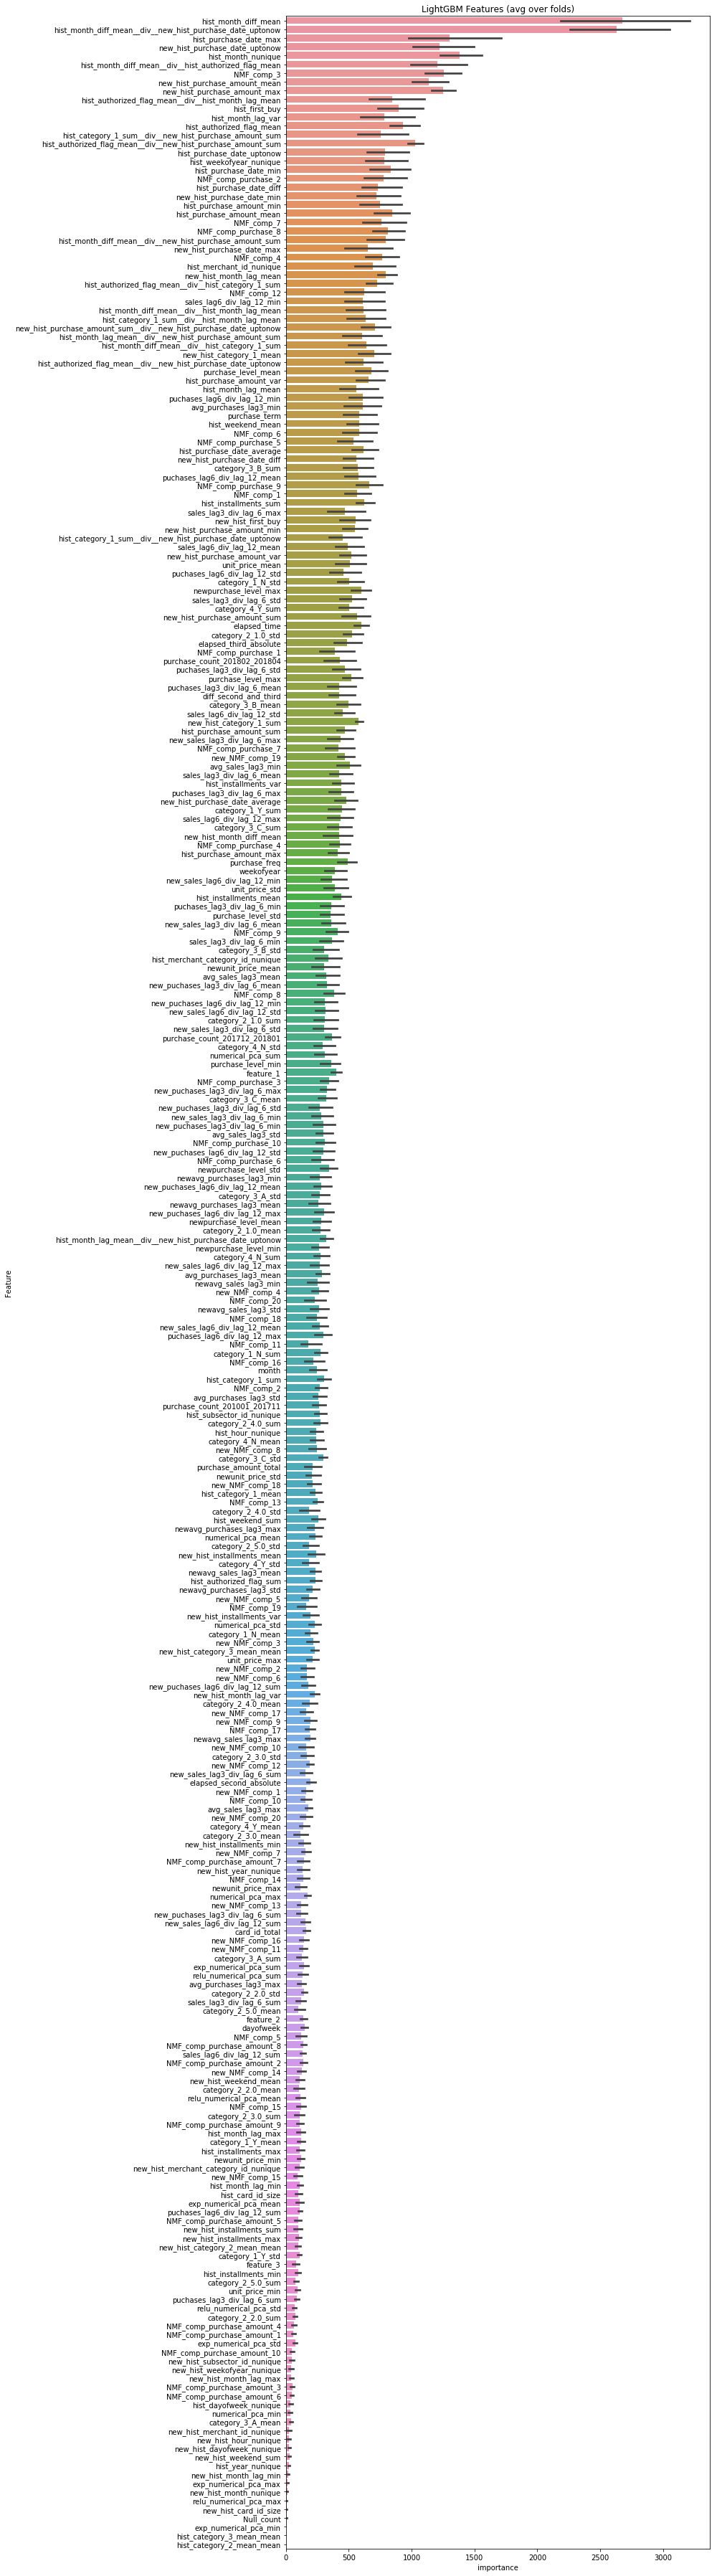

In [21]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [32]:
df_train_high_imp_columns = feature_importance_df[feature_importance_df.importance >= 500].Feature.values

In [33]:
#original
param = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.004,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train,df_train['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_high_imp_columns], label=target.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_high_imp_columns], label=target.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][df_train_high_imp_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_high_imp_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(df_test[df_train_high_imp_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.73855	valid_1's rmse: 3.77385
[200]	training's rmse: 3.67067	valid_1's rmse: 3.73254
[300]	training's rmse: 3.62377	valid_1's rmse: 3.70939
[400]	training's rmse: 3.58831	valid_1's rmse: 3.69502
[500]	training's rmse: 3.56062	valid_1's rmse: 3.68501
[600]	training's rmse: 3.53664	valid_1's rmse: 3.6777
[700]	training's rmse: 3.51627	valid_1's rmse: 3.67254
[800]	training's rmse: 3.49796	valid_1's rmse: 3.66855
[900]	training's rmse: 3.48184	valid_1's rmse: 3.66535
[1000]	training's rmse: 3.46651	valid_1's rmse: 3.66247
[1100]	training's rmse: 3.45242	valid_1's rmse: 3.66041
[1200]	training's rmse: 3.4389	valid_1's rmse: 3.65835
[1300]	training's rmse: 3.42678	valid_1's rmse: 3.65645
[1400]	training's rmse: 3.41526	valid_1's rmse: 3.65498
[1500]	training's rmse: 3.40384	valid_1's rmse: 3.65362
[1600]	training's rmse: 3.39268	valid_1's rmse: 3.65256
[1700]	training's rmse: 3.38196	valid_1's rms

[2200]	training's rmse: 3.32328	valid_1's rmse: 3.67016
[2300]	training's rmse: 3.31438	valid_1's rmse: 3.66989
[2400]	training's rmse: 3.30538	valid_1's rmse: 3.6695
[2500]	training's rmse: 3.29663	valid_1's rmse: 3.66952
[2600]	training's rmse: 3.28791	valid_1's rmse: 3.66966
[2700]	training's rmse: 3.28004	valid_1's rmse: 3.66969
[2800]	training's rmse: 3.27203	valid_1's rmse: 3.66966
Early stopping, best iteration is:
[2402]	training's rmse: 3.30524	valid_1's rmse: 3.66947
fold 4
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 3.73853	valid_1's rmse: 3.77612
[200]	training's rmse: 3.67029	valid_1's rmse: 3.73475
[300]	training's rmse: 3.62271	valid_1's rmse: 3.71283
[400]	training's rmse: 3.58628	valid_1's rmse: 3.69989
[500]	training's rmse: 3.55752	valid_1's rmse: 3.69223
[600]	training's rmse: 3.53315	valid_1's rmse: 3.68589
[700]	training's rmse: 3.51227	valid_1's rmse: 3.6816
[800]	training's rmse: 3.49398	valid_1's rmse: 3.67838
[900]	tra

3.6456149902748076

In [34]:
df_train2 = df_train[df_train.target >= -20].reset_index(drop=True)
target2 = df_train2["target"]

#original
param2 = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.01,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train2))
predictions2 = np.zeros(len(df_test))
feature_importance_df2 = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train2,df_train2['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train2.iloc[trn_idx][df_train_columns], label=target2.iloc[trn_idx])
    val_data = lgb.Dataset(df_train2.iloc[val_idx][df_train_columns], label=target2.iloc[val_idx])
    num_round = 10000
    clf = lgb.train(param2, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train2.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df2 = pd.concat([feature_importance_df2, fold_importance_df], axis=0)
    
    predictions2 += clf.predict(df_test[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target2))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.6068	valid_1's rmse: 1.607
[200]	training's rmse: 1.57521	valid_1's rmse: 1.57856
[300]	training's rmse: 1.5597	valid_1's rmse: 1.56735
[400]	training's rmse: 1.54902	valid_1's rmse: 1.56163
[500]	training's rmse: 1.5405	valid_1's rmse: 1.55807
[600]	training's rmse: 1.53333	valid_1's rmse: 1.55593
[700]	training's rmse: 1.52693	valid_1's rmse: 1.55454
[800]	training's rmse: 1.52114	valid_1's rmse: 1.55368
[900]	training's rmse: 1.51584	valid_1's rmse: 1.55312
[1000]	training's rmse: 1.51071	valid_1's rmse: 1.5527
[1100]	training's rmse: 1.50596	valid_1's rmse: 1.55229
[1200]	training's rmse: 1.50145	valid_1's rmse: 1.55194
[1300]	training's rmse: 1.49701	valid_1's rmse: 1.5517
[1400]	training's rmse: 1.49275	valid_1's rmse: 1.5516
[1500]	training's rmse: 1.48854	valid_1's rmse: 1.55154
[1600]	training's rmse: 1.48429	valid_1's rmse: 1.55155
[1700]	training's rmse: 1.48024	valid_1's rmse: 1.5

[500]	training's rmse: 1.53514	valid_1's rmse: 1.58423
[600]	training's rmse: 1.52787	valid_1's rmse: 1.58197
[700]	training's rmse: 1.52154	valid_1's rmse: 1.58048
[800]	training's rmse: 1.51578	valid_1's rmse: 1.57963
[900]	training's rmse: 1.51041	valid_1's rmse: 1.57917
[1000]	training's rmse: 1.50541	valid_1's rmse: 1.57877
[1100]	training's rmse: 1.50062	valid_1's rmse: 1.57844
[1200]	training's rmse: 1.49583	valid_1's rmse: 1.57819
[1300]	training's rmse: 1.49138	valid_1's rmse: 1.57803
[1400]	training's rmse: 1.48704	valid_1's rmse: 1.57783
[1500]	training's rmse: 1.48277	valid_1's rmse: 1.57772
[1600]	training's rmse: 1.47868	valid_1's rmse: 1.57763
[1700]	training's rmse: 1.47463	valid_1's rmse: 1.57744
[1800]	training's rmse: 1.47058	valid_1's rmse: 1.57747
[1900]	training's rmse: 1.46651	valid_1's rmse: 1.5774
[2000]	training's rmse: 1.46266	valid_1's rmse: 1.57731
[2100]	training's rmse: 1.45884	valid_1's rmse: 1.57736
[2200]	training's rmse: 1.45511	valid_1's rmse: 1.5772

1.5566402056162099

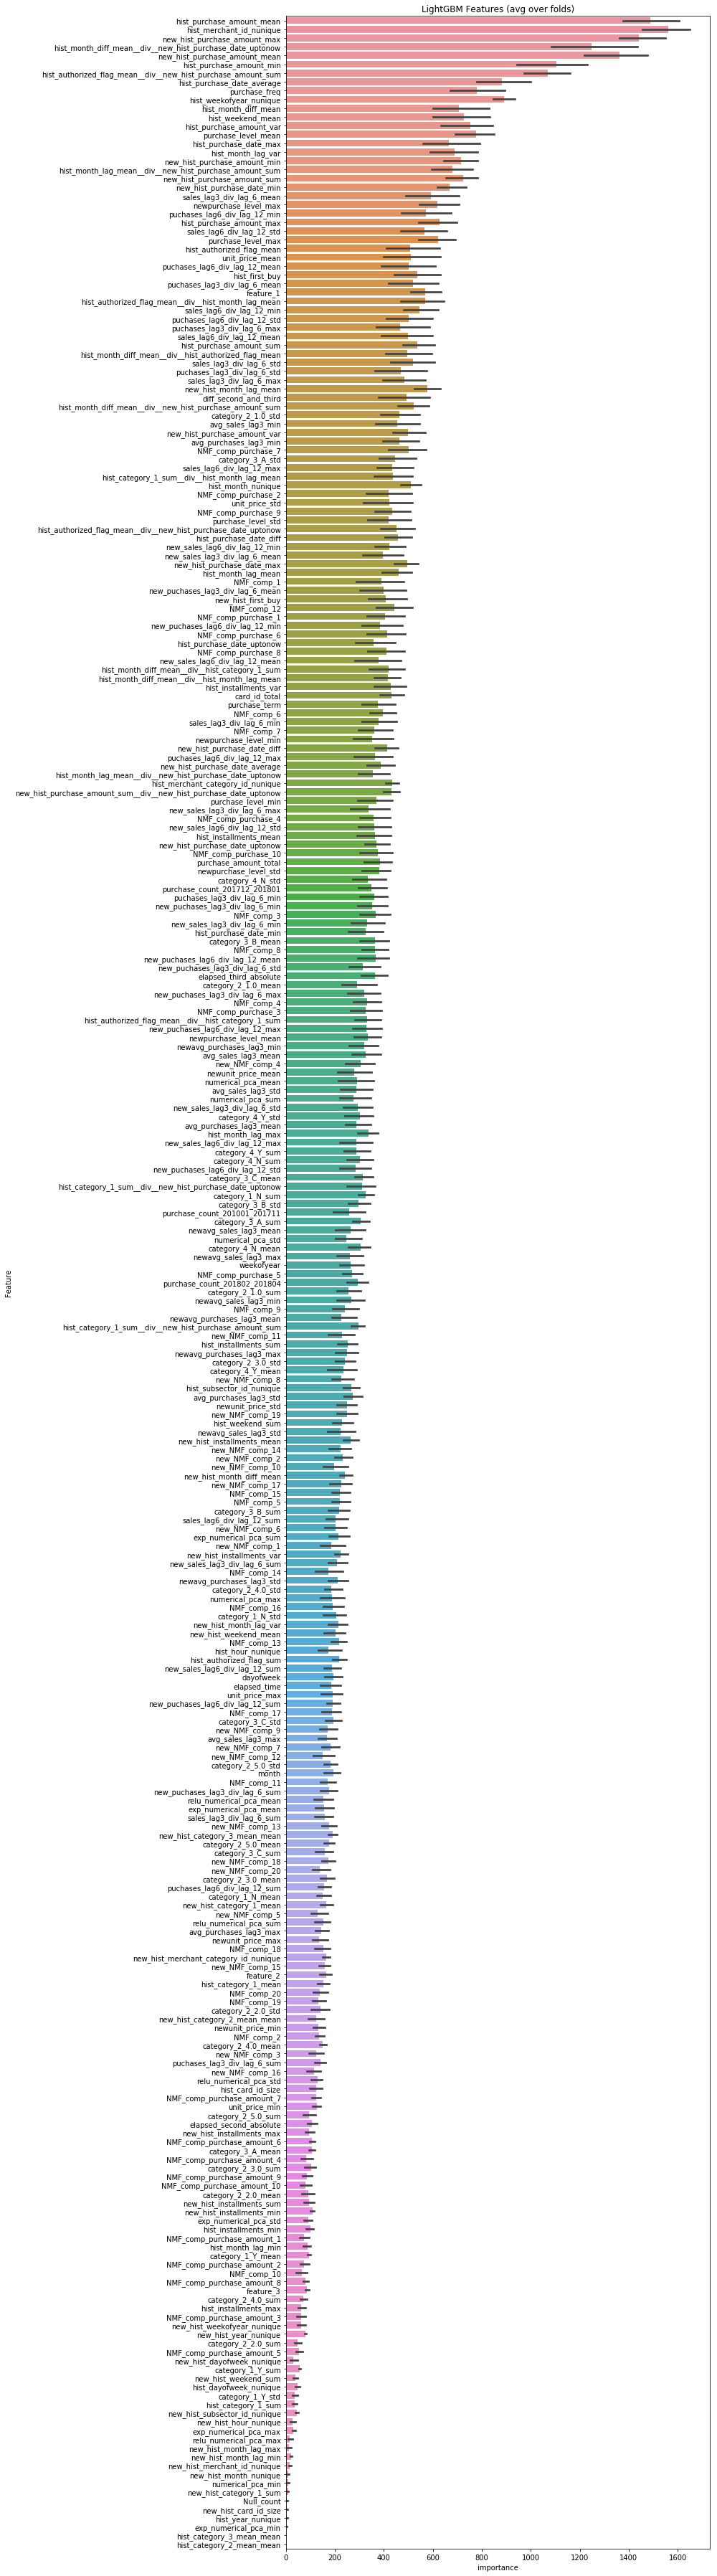

In [35]:
cols = (feature_importance_df2[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df2.loc[feature_importance_df2.Feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="Feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [40]:
df_train_high_imp_columns2 = feature_importance_df2[feature_importance_df2.importance >= 300].Feature.values

In [41]:
#original
param2 = {
    'num_leaves': 31,  # 31
    'min_data_in_leaf': 30,
    'objective':'regression',
    'max_depth': -1,
    'learning_rate': 0.01,
    "min_child_samples": 20,
    "boosting": "gbdt",
    "feature_fraction": 0.9,
    "bagging_freq": 1,
    "bagging_fraction": 0.9 ,
    "bagging_seed": 11,
    "metric": 'rmse',
    "lambda_l1": 0.1,
    "verbosity": -1,
    "nthread": 4,
    "random_state": 1000 #4590
}


folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1000) #4590
oof = np.zeros(len(df_train2))
predictions2 = np.zeros(len(df_test))
feature_importance_df2 = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train2,df_train2['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(df_train2.iloc[trn_idx][df_train_high_imp_columns2], label=target2.iloc[trn_idx])
    val_data = lgb.Dataset(df_train2.iloc[val_idx][df_train_high_imp_columns2], label=target2.iloc[val_idx])
    num_round = 10000
    clf = lgb.train(param2, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 400)
    oof[val_idx] = clf.predict(df_train2.iloc[val_idx][df_train_high_imp_columns2], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_high_imp_columns2
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df2 = pd.concat([feature_importance_df2, fold_importance_df], axis=0)
    
    predictions2 += clf.predict(df_test[df_train_high_imp_columns2], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target2))

fold 0
Training until validation scores don't improve for 400 rounds.
[100]	training's rmse: 1.6069	valid_1's rmse: 1.60664
[200]	training's rmse: 1.57537	valid_1's rmse: 1.57813
[300]	training's rmse: 1.56008	valid_1's rmse: 1.56687
[400]	training's rmse: 1.54967	valid_1's rmse: 1.56111
[500]	training's rmse: 1.54123	valid_1's rmse: 1.55771
[600]	training's rmse: 1.534	valid_1's rmse: 1.55573
[700]	training's rmse: 1.52763	valid_1's rmse: 1.55435
[800]	training's rmse: 1.52192	valid_1's rmse: 1.55352
[900]	training's rmse: 1.51678	valid_1's rmse: 1.55285
[1000]	training's rmse: 1.51181	valid_1's rmse: 1.55245
[1100]	training's rmse: 1.50708	valid_1's rmse: 1.55211
[1200]	training's rmse: 1.50259	valid_1's rmse: 1.55192
[1300]	training's rmse: 1.49828	valid_1's rmse: 1.55182
[1400]	training's rmse: 1.49409	valid_1's rmse: 1.55179
[1500]	training's rmse: 1.48989	valid_1's rmse: 1.5517
[1600]	training's rmse: 1.48568	valid_1's rmse: 1.55153
[1700]	training's rmse: 1.48167	valid_1's rmse:

[2100]	training's rmse: 1.46043	valid_1's rmse: 1.57713
[2200]	training's rmse: 1.45665	valid_1's rmse: 1.57714
[2300]	training's rmse: 1.45293	valid_1's rmse: 1.57707
[2400]	training's rmse: 1.44923	valid_1's rmse: 1.57708
[2500]	training's rmse: 1.44548	valid_1's rmse: 1.57701
[2600]	training's rmse: 1.44177	valid_1's rmse: 1.57697
[2700]	training's rmse: 1.43815	valid_1's rmse: 1.577
[2800]	training's rmse: 1.4347	valid_1's rmse: 1.57696
[2900]	training's rmse: 1.43132	valid_1's rmse: 1.57702
Early stopping, best iteration is:
[2581]	training's rmse: 1.44251	valid_1's rmse: 1.57694


1.5572625247834961

In [43]:
df_prediction = pd.DataFrame({"prediction1":predictions, "prediction2": predictions2})

In [44]:
df_prediction.head()

,prediction1,prediction2
0,-1.978086,-0.459910
1,-0.324033,-0.203519
2,-1.000638,-0.386481
3,-0.000395,-0.058948
4,-1.544014,-1.769880


In [45]:
final_predictions = np.zeros(df_prediction.shape[0])
for i, r in df_prediction.iterrows():
    if r[0] < 0:
        final_predictions[i] = r[0]
    else:
        final_predictions[i] = r[1]

In [46]:
sub_df = pd.DataFrame({"card_id":df_test["card_id"].values})
sub_df["target"] = final_predictions
sub_df.to_csv("../output/submission_model20181222.csv", index=False)